# Tutorial

## Introduction

Computer simulations of the Earth’s climate and weather generate huge amounts of
data. These data are often persisted on high-performance computing (HPC) systems
or in the cloud across multiple data assets in a variety of formats (netCDF,
Zarr, etc.). Finding, investigating, and loading these data assets into
compute-ready data containers costs time and effort. The user should know what
data are available and their associated metadata, preferably before loading a
specific data asset and analyzing it.

In this notebook, we demonstrate
[intake-esm](https://github.com/NCAR/intake-esm), a Python package and an
[intake](https://github.com/intake/intake) plugin with aims of facilitating:

- the discovery of earth's climate and weather datasets.
- the ingestion of these datasets into
  [xarray](https://github.com/pydata/xarray) dataset containers.

The common/popular starting point for finding and investigating large datasets
is with a data catalog. A _data catalog_ is a collection of metadata, combined
with search tools, that helps data analysts and other users to find the data
they need. For a user to take full advantage of intake-esm, they must point it
to an _Earth System Model (ESM) data catalog_. This is a JSON-formatted file
that conforms to the ESM collection specification.

## ESM Collection Specification

The [ESM collection specification](https://github.com/NCAR/esm-collection-spec)
provides a machine-readable format for describing a wide range of climate and
weather datasets, with a goal of making it easier to index and discover climate
and weather data assets. An asset is any netCDF/HDF file or Zarr store that
contains relevant data.

An ESM data catalog serves as an inventory of available data, and provides
information to explore the existing data assets. Additionally, an ESM catalog
can contain information on how to aggregate compatible groups of data assets
into singular xarray datasets.


## Loading a catalog

Intake-esm works as follows:

1. Load an ESM data catalog file. The JSON-based catalog file must conform to
   the
   [ESM Collection Specification](https://github.com/NCAR/esm-collection-spec).
2. Create an
   [intake catalog object](https://intake.readthedocs.io/en/latest/catalog.html).
3. Use aggregation information from the ESM data catalog to construct keys for
   available high-level aggregated xarray datasets, called catalog entries.


To begin, import intake:


In [1]:
import intake

In [2]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
print(type(col))
col

/Users/abanihi/opt/miniconda3/envs/intake-esm-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'intake_esm.core.esm_datastore'>


,unique
activity_id,15
institution_id,33
source_id,76
experiment_id,105
member_id,204
table_id,29
variable_id,373
grid_label,10
zstore,282265
dcpp_init_year,60


The summary above tells us that this catalog contains over 268,000 data assets.
We can get more information on the individual data assets contained in the
catalog by calling the underlying dataframe created when it is initialized:


### Catalog Contents


In [3]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


The first data asset listed in the catalog contains:

- the ambient aerosol optical thickness at 550nm (`variable_id='od550aer'`), as
  a function of latitude, longitude, time,
- in an individual climate model experiment with the Taiwan Earth System Model
  1.0 model (`source_id='TaiESM1'`),
- forced by the _Historical transient with SSTs prescribed from historical_
  experiment (`experiment_id='histSST'`),
- developed by the Taiwan Research Center for Environmental Changes
  (`instution_id='AS-RCEC'`),
- run as part of the Aerosols and Chemistry Model Intercomparison Project
  (`activity_id='AerChemMIP'`)

And is located in Google Cloud Storage at
`gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/r1i1p1f1/AERmon/od550aer/gn/`.


## Data Sources


Intake-esm uses the `key_template` property in order to create data source keys.
The keys can be accesssed via `.keys()` method:


In [4]:
print(col.key_template)

activity_id.institution_id.source_id.experiment_id.table_id.grid_label


In [5]:
# number of data sources
len(col.keys())

4265

Let's take a look at the first ten entries


In [6]:
list(col.keys())[:10]

['AerChemMIP.AS-RCEC.TaiESM1.histSST.AERmon.gn',
 'AerChemMIP.BCC.BCC-ESM1.histSST.AERmon.gn',
 'AerChemMIP.BCC.BCC-ESM1.histSST.Amon.gn',
 'AerChemMIP.BCC.BCC-ESM1.piClim-CH4.Amon.gn',
 'AerChemMIP.BCC.BCC-ESM1.piClim-NTCF.Amon.gn',
 'AerChemMIP.BCC.BCC-ESM1.piClim-control.AERmon.gn',
 'AerChemMIP.BCC.BCC-ESM1.piClim-control.Amon.gn',
 'AerChemMIP.BCC.BCC-ESM1.ssp370.AERmon.gn',
 'AerChemMIP.BCC.BCC-ESM1.ssp370.Amon.gn',
 'AerChemMIP.BCC.BCC-ESM1.ssp370.LImon.gn']

Each key in this list points to the assets (files) that will be merged into a
single xarray dataset.


In [7]:
data_source = col["AerChemMIP.BCC.BCC-ESM1.piClim-control.AERmon.gn"]
print(type(data_source))
data_source

<class 'intake_esm.source.ESMGroupDataSource'>


,zstore,variable_id,member_id
73,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-control/r1i1p1f1/AERmon/mmrbc/gn/,mmrbc,r1i1p1f1
74,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-control/r1i1p1f1/AERmon/mmrdust/gn/,mmrdust,r1i1p1f1
75,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-control/r1i1p1f1/AERmon/mmroa/gn/,mmroa,r1i1p1f1
76,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-control/r1i1p1f1/AERmon/mmrso4/gn/,mmrso4,r1i1p1f1
77,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-control/r1i1p1f1/AERmon/mmrss/gn/,mmrss,r1i1p1f1


## Search and discovery

If the catalog has too many data sources to comfortably know the keys
corresponding to datasets of interest, you can narrow it by searching via the
`unique()` and `search()` methods.

### Finding unique entries

Let's query the data to see what models (`source_id`), experiments
(`experiment_id`) and temporal frequencies (`table_id`) are available.


In [8]:
import pprint

uni_dict = col.unique(["source_id", "experiment_id", "table_id"])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 105,
                   'values': ['1pctCO2', '1pctCO2-bgc', '1pctCO2-rad',
                              'abrupt-0p5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2',
                              'abrupt-solm4p', 'abrupt-solp4p', 'amip',
                              'amip-4xCO2', 'amip-future4K', 'amip-hist',
                              'amip-lwoff', 'amip-m4K', 'amip-p4K',
                              'amip-p4K-lwoff', 'aqua-4xCO2', 'aqua-control',
                              'aqua-control-lwoff', 'aqua-p4K',
                              'aqua-p4K-lwoff', 'control-1950', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-amv-ExTrop-neg',
                              'dcppC-amv-ExTrop-pos', 'dcppC-amv-Trop-neg',
                              'dcppC-amv-Trop-pos', 'dcppC-amv-neg',
                              'dcppC-amv-pos', 'dcppC-atl-control',
                              'dcppC-atl-pacemaker', 'dcppC-hindcast-noAgung',
                 

### Searching for specific datasets

The `search()` method allows the user to perform a query on a catalog using
keyword arguments. This method returns a subset of the catalog with all the
entries that match the provided query.

In the example below, we are are going to search for the following:

- variables: `o2` which stands for
  `mole_concentration_of_dissolved_molecular_oxygen_in_sea_water`
- experiments: `['historical', 'ssp585']`:
  - `historical`: all forcing of the recent past.
  - `ssp585`: emission-driven
    [RCP8.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway)
    based on SSP5.
- table_id: `Oyr` which stands for annual mean variables on the ocean grid.
- grid_label: `gn` which stands for data reported on a model's native grid.

For more details on the CMIP6 vocabulary, please check this
[website](http://clipc-services.ceda.ac.uk/dreq/index.html), and
[Core Controlled Vocabularies (CVs) for use in CMIP6](https://github.com/WCRP-CMIP/CMIP6_CVs)
GitHub repository.


In [9]:
cat = col.search(
    experiment_id=["historical", "ssp585"],
    table_id="Oyr",
    variable_id="o2",
    grid_label="gn",
)

cat

,unique
activity_id,2
institution_id,9
source_id,10
experiment_id,2
member_id,45
table_id,1
variable_id,1
grid_label,1
zstore,138
dcpp_init_year,0


In [10]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5-CanOE,historical,r1i1p2f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5-CanOE/historical...,NaN,20190429
1,CMIP,CCCma,CanESM5-CanOE,historical,r2i1p2f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5-CanOE/historical...,NaN,20190429
2,CMIP,CCCma,CanESM5-CanOE,historical,r3i1p2f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5-CanOE/historical...,NaN,20190429
3,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...,NaN,20190429
4,CMIP,CCCma,CanESM5,historical,r10i1p2f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...,NaN,20190429


### Enhanced search: enforce query criteria via `require_all_on` argument

By default intake-esm's `search()` method returns entries that fulfill any of
the criteria specified in the query. Today intake-esm can return entries that
fulfill all query criteria when the user supplies the `require_all_on` argument.
The `require_all_on` parameter can be **a dataframe column** or **a list of
dataframe columns** across which all elements must satisfy the query criteria.
The `require_all_on` argument is best explained with the following example.

Let's define a query for our collection that requests multiple `variable_ids`
and multiple `experiment_ids` from the Omon `table_id`, all from 3 different
`source_ids`:


In [11]:
# Define our query
query = dict(
    variable_id=["thetao", "o2"],
    experiment_id=["historical", "ssp245", "ssp585"],
    table_id=["Omon"],
    source_id=["ACCESS-ESM1-5", "AWI-CM-1-1-MR", "FGOALS-f3-L"],
)

Now, let's use this query to search for all assets in the collection that
satisfy any combination of these requests (i.e., with `require_all_on=None`,
which is the default):


In [12]:
col_subset = col.search(**query)

col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-ESM1-5,3,2,1
AWI-CM-1-1-MR,3,1,1
FGOALS-f3-L,1,1,1


As you can see, the search results above include `source_ids` for which we only
have one of the two variables, and one or two of the three experiments.

We can tell intake-esm to discard any `source_id` that doesn't have both
variables `["thetao", "o2"]` and all three experiments
`["historical", "ssp245", "ssp585"]` by passing `require_all_on=["source_id"]`
to the search method:

Next, let's search for assets that fulfill our query with
`require_all_on=["source_id"]`:


In [13]:
col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-ESM1-5,3,2,1


Notice that with the `require_all_on=["source_id"]` option, the only
`source_id that` was returned by our query was the `source_id` for which all of
the variables and experiments were found.


## Loading datasets

As pointed out earlier, intake-esm contains logic to merge the query results
into higher level
[xarray datasets](http://xarray.pydata.org/en/stable/api.html#dataset).

Once you have identified one/more dataset(s), you can load it/them into xarray
dataset via:

- `to_dask()` method. This method is available on the **data source object**.
  Calling this method on a data source yields **a single**, high-level
  aggregated xarray dataset.
- `to_dataset_dict()` method. This method is available on the **catalog
  object**. Calling this method on a catalog object yields **a dictionary** of
  high-level aggregated xarray datasets.

The logic for merging/concatenating the query results into higher level xarray
datasets is provided in the input JSON file, under `aggregation_control`:

```javascript

"aggregation_control": {
  "variable_column_name": "variable_id",
  "groupby_attrs": [
    "activity_id",
    "institution_id",
    "source_id",
    "experiment_id",
    "table_id",
    "grid_label"
  ],
  "aggregations": [{
      "type": "union",
      "attribute_name": "variable_id"
    },

    {
      "type": "join_new",
      "attribute_name": "member_id",
      "options": {
        "coords": "minimal",
        "compat": "override"
      }
    },
    {
      "type": "join_new",
      "attribute_name": "dcpp_init_year",
      "options": {
        "coords": "minimal",
        "compat": "override"
      }
    }
  ]
}

```

This information is also available as properties of
`intake_esm.core.esm_datastore` instances:


In [14]:
col.aggregation_info

AggregationInfo(groupby_attrs=['activity_id', 'institution_id', 'source_id', 'experiment_id', 'table_id', 'grid_label'], variable_column_name='variable_id', aggregations=[{'type': 'union', 'attribute_name': 'variable_id'}, {'type': 'join_new', 'attribute_name': 'member_id', 'options': {'coords': 'minimal', 'compat': 'override'}}, {'type': 'join_new', 'attribute_name': 'dcpp_init_year', 'options': {'coords': 'minimal', 'compat': 'override'}}], agg_columns=['variable_id', 'member_id', 'dcpp_init_year'], aggregation_dict={'variable_id': {'type': 'union'}, 'member_id': {'type': 'join_new', 'options': {'coords': 'minimal', 'compat': 'override'}}, 'dcpp_init_year': {'type': 'join_new', 'options': {'coords': 'minimal', 'compat': 'override'}}})

In [15]:
col.aggregation_dict

{'variable_id': {'type': 'union'},
 'member_id': {'type': 'join_new',
  'options': {'coords': 'minimal', 'compat': 'override'}},
 'dcpp_init_year': {'type': 'join_new',
  'options': {'coords': 'minimal', 'compat': 'override'}}}

In [16]:
# Dataframe columns used to determine groups of compatible datasets.
col.groupby_attrs

['activity_id',
 'institution_id',
 'source_id',
 'experiment_id',
 'table_id',
 'grid_label']

### Using `to_dask()`

From our previous `cat` catalog object, Let's

- extract a key of interest from the catalog object. This will yield a data
  source corresponding to a single, high-level aggregated xarray dataset.
- use `to_dask()` method to load the data source into an xarray dataset.


In [17]:
len(cat)

18

In [18]:
list(cat.keys())[:10]

['CMIP.CCCma.CanESM5.historical.Oyr.gn',
 'CMIP.CCCma.CanESM5-CanOE.historical.Oyr.gn',
 'CMIP.CSIRO.ACCESS-ESM1-5.historical.Oyr.gn',
 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.Oyr.gn',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn',
 'CMIP.MIROC.MIROC-ES2L.historical.Oyr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Oyr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Oyr.gn',
 'CMIP.NCC.NorESM2-LM.historical.Oyr.gn',
 'CMIP.NCC.NorESM2-MM.historical.Oyr.gn']

In [19]:
data_source = cat["CMIP.CCCma.CanESM5.historical.Oyr.gn"]
ds = data_source(
    zarr_kwargs={"consolidated": True, "decode_times": True}
).to_dask()
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, lev: 45, member_id: 35, time: 165, vertices: 4)
Coordinates:
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    time_bnds           (time, bnds) object dask.array<chunksize=(165, 2), meta=np.ndarray>
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-07-02 12:00:00 ... 2014-07-02 12:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * lev                 (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
  * member_id           (member_id) <U9 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p2f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    o2                  (member_id, time, lev, j, i) float32 dask.array<chunksize=(1, 12, 45, 291, 360), meta=np.ndarray>
Attributes:
    sub_experiment_id:           none
    CCCma_runid:                 p2-his09
    realm:                       ocnBgchem
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    CCCma_model_hash:            Unknown
    tracking_id:                 hdl:21.14100/41426118-701c-482b-ae16-82932e4...
    cmor_version:                3.4.0
    sub_experiment:              none
    grid:                        ORCA1 tripolar grid, 1 deg with refinement t...
    license:                     CMIP6 model data produced by The Government ...
    nominal_resolution:          100 km
    realization_index:           9
    creation_date:               2019-05-30T08:58:45Z
    initialization_index:        1
    parent_source_id:            CanESM5
    institution_id:              CCCma
    Conventions:                 CF-1.7 CMIP-6.2
    history:                     2019-05-02T13:53:53Z ;rewrote data to be con...
    table_id:                    Oyr
    variable_id:                 o2
    parent_activity_id:          CMIP
    branch_time_in_parent:       1496500.0
    status:                      2019-10-25;created;by nhn2@columbia.edu
    experiment:                  all-forcing simulation of the recent past
    forcing_index:               1
    branch_time_in_child:        0.0
    title:                       CanESM5 output prepared for CMIP6
    institution:                 Canadian Centre for Climate Modelling and An...
    product:                     model-output
    branch_method:               Spin-up documentation
    source_type:                 AOGCM
    YMDH_branch_time_in_parent:  5950:01:01:00
    parent_experiment_id:        piControl
    data_specs_version:          01.00.29
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    variant_label:               r9i1p2f1
    CCCma_parent_runid:          p2-pictrl
    experiment_id:               historical
    source_id:                   CanESM5
    mip_era:                     CMIP6
    references:                  Geophysical Model Development Special issue ...
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid_label:                  gn
    intake_esm_varname:          ['o2']
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    parent_time_units:           days since 1850-01-01 0:0:0.0
    version:                     v20190429
    parent_mip_era:              CMIP6
    external_variables:          areacello volcello
    frequency:                   yr
    activity_id:                 CMIP
    YMDH_branch_time_in_child:   1850:01:01:00
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historic

### Using `to_dataset_dict()`

Say you want to load datasets corresponding to all 18 keys instead of just
extracting a single key from catalog object. You need to use the
`to_dataset_dict()` method. This method will return a dictionary of aggregate
xarray datasets as the name hints.


In [20]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [21]:
[key for key in dset_dict.keys()]

['ScenarioMIP.DWD.MPI-ESM1-2-HR.ssp585.Oyr.gn',
 'CMIP.CCCma.CanESM5-CanOE.historical.Oyr.gn',
 'ScenarioMIP.MIROC.MIROC-ES2L.ssp585.Oyr.gn',
 'ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.Oyr.gn',
 'CMIP.CSIRO.ACCESS-ESM1-5.historical.Oyr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Oyr.gn',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Oyr.gn',
 'CMIP.NCC.NorESM2-MM.historical.Oyr.gn',
 'ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Oyr.gn',
 'CMIP.MIROC.MIROC-ES2L.historical.Oyr.gn',
 'ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.Oyr.gn',
 'ScenarioMIP.CCCma.CanESM5-CanOE.ssp585.Oyr.gn',
 'CMIP.CCCma.CanESM5.historical.Oyr.gn',
 'CMIP.NCC.NorESM2-LM.historical.Oyr.gn',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Oyr.gn',
 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.Oyr.gn',
 'ScenarioMIP.CCCma.CanESM5.ssp585.Oyr.gn']

We can access a particular dataset as follows:


In [22]:
ds = dset_dict["CMIP.CCCma.CanESM5.historical.Oyr.gn"]
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, lev: 45, member_id: 35, time: 165, vertices: 4)
Coordinates:
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    time_bnds           (time, bnds) object dask.array<chunksize=(165, 2), meta=np.ndarray>
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-07-02 12:00:00 ... 2014-07-02 12:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * lev                 (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
  * member_id           (member_id) <U9 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p2f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    o2                  (member_id, time, lev, j, i) float32 dask.array<chunksize=(1, 12, 45, 291, 360), meta=np.ndarray>
Attributes:
    sub_experiment_id:           none
    CCCma_runid:                 p2-his09
    realm:                       ocnBgchem
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    CCCma_model_hash:            Unknown
    tracking_id:                 hdl:21.14100/41426118-701c-482b-ae16-82932e4...
    cmor_version:                3.4.0
    sub_experiment:              none
    grid:                        ORCA1 tripolar grid, 1 deg with refinement t...
    license:                     CMIP6 model data produced by The Government ...
    nominal_resolution:          100 km
    realization_index:           9
    creation_date:               2019-05-30T08:58:45Z
    initialization_index:        1
    parent_source_id:            CanESM5
    institution_id:              CCCma
    Conventions:                 CF-1.7 CMIP-6.2
    history:                     2019-05-02T13:53:53Z ;rewrote data to be con...
    table_id:                    Oyr
    variable_id:                 o2
    parent_activity_id:          CMIP
    branch_time_in_parent:       1496500.0
    status:                      2019-10-25;created;by nhn2@columbia.edu
    experiment:                  all-forcing simulation of the recent past
    forcing_index:               1
    branch_time_in_child:        0.0
    title:                       CanESM5 output prepared for CMIP6
    institution:                 Canadian Centre for Climate Modelling and An...
    product:                     model-output
    branch_method:               Spin-up documentation
    source_type:                 AOGCM
    YMDH_branch_time_in_parent:  5950:01:01:00
    parent_experiment_id:        piControl
    data_specs_version:          01.00.29
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    variant_label:               r9i1p2f1
    CCCma_parent_runid:          p2-pictrl
    experiment_id:               historical
    source_id:                   CanESM5
    mip_era:                     CMIP6
    references:                  Geophysical Model Development Special issue ...
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid_label:                  gn
    intake_esm_varname:          ['o2']
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    parent_time_units:           days since 1850-01-01 0:0:0.0
    version:                     v20190429
    parent_mip_era:              CMIP6
    external_variables:          areacello volcello
    frequency:                   yr
    activity_id:                 CMIP
    YMDH_branch_time_in_child:   1850:01:01:00
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historic

Let’s create a quick plot for a slice of the data:


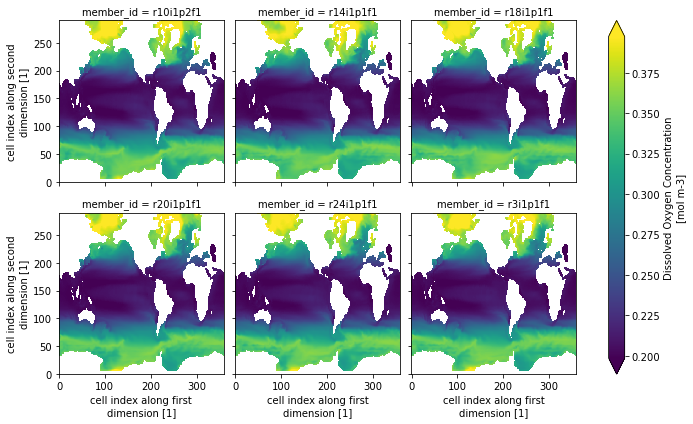

In [23]:
ds.o2.isel(time=0, lev=0, member_id=range(1, 24, 4)).plot(
    col="member_id", col_wrap=3, robust=True
)

## Using custom preprocessing functions

When comparing many models it is often necessary to preprocess (e.g. rename
certain variables) them before running some analysis step. The `preprocess`
argument lets the user pass a function, which is executed for each loaded asset
before aggregations.


In [24]:
cat_pp = col.search(
    experiment_id=["historical"],
    table_id="Oyr",
    variable_id="o2",
    grid_label="gn",
    source_id=["IPSL-CM6A-LR", "CanESM5"],
    member_id="r10i1p1f1",
)
cat_pp.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...,NaN,20190429
1,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803


In [25]:
# load the example
dset_dict_raw = cat_pp.to_dataset_dict(zarr_kwargs={"consolidated": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [26]:
for k, ds in dset_dict_raw.items():
    print(f"dataset key={k}\n\tdimensions={sorted(list(ds.dims))}\n")

dataset key=CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn
	dimensions=['axis_nbounds', 'member_id', 'nvertex', 'olevel', 'time', 'x', 'y']

dataset key=CMIP.CCCma.CanESM5.historical.Oyr.gn
	dimensions=['bnds', 'i', 'j', 'lev', 'member_id', 'time', 'vertices']



<div class="alert alert-info">

**Note:**  
Note that both models follow a different naming scheme. We can define a little
helper function and pass it to `.to_dataset_dict()` to fix this. For
demonstration purposes we will focus on the vertical level dimension which is
called `lev` in `CanESM5` and `olevel` in `IPSL-CM6A-LR`.

</div>


In [27]:
def helper_func(ds):
    """Rename `olevel` dim to `lev`"""
    ds = ds.copy()
    # a short example
    if "olevel" in ds.dims:
        ds = ds.rename({"olevel": "lev"})
    return ds

In [28]:
dset_dict_fixed = cat_pp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, preprocess=helper_func
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [29]:
for k, ds in dset_dict_fixed.items():
    print(f"dataset key={k}\n\tdimensions={sorted(list(ds.dims))}\n")

dataset key=CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn
	dimensions=['axis_nbounds', 'lev', 'member_id', 'nvertex', 'time', 'x', 'y']

dataset key=CMIP.CCCma.CanESM5.historical.Oyr.gn
	dimensions=['bnds', 'i', 'j', 'lev', 'member_id', 'time', 'vertices']



This was just an example for one dimension.

<div class="alert alert-info">

**Note:**  
Check out
[cmip6-preprocessing package](https://github.com/jbusecke/cmip6_preprocessing)
for a full renaming function for all available CMIP6 models and some other
utilities.

</div>


## Conclusion

- With intake-esm, much of the toil associated with discovering, loading, and
  consolidating data assets can be eliminated. In addition to making
  computations on huge datasets more accessible to the scientific community, the
  package also promotes reproducibility by providing simple methodology to
  create consistent datasets.
- Intake-esm gives climate scientists the means to create and distribute large
  data collections with instructions on how to use them essentially written into
  their ESM specifications.
